In [26]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [27]:
data = pd.read_csv('Dataset.csv', engine='python', encoding='latin-1')

In [28]:
data.columns=["label","time","date","query","username","text"]

In [29]:
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [30]:
data = data[["label","text"]]

In [31]:
data['label'][data['label']==4]=1

In [32]:
data_pos = data[data['label']==1]
data_neg = data[data['label']==0]

In [33]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [34]:
data = pd.concat([data_pos,data_neg])

In [35]:
data['text']=data['text'].str.lower()

### stop-word remove

In [36]:
stopwords_list = stopwords.words('english')

In [37]:
from nltk.corpus import stopwords
",".join(stopwords.words('english'))

"i,me,my,myself,we,our,ours,ourselves,you,you're,you've,you'll,you'd,your,yours,yourself,yourselves,he,him,his,himself,she,she's,her,hers,herself,it,it's,its,itself,they,them,their,theirs,themselves,what,which,who,whom,this,that,that'll,these,those,am,is,are,was,were,be,been,being,have,has,had,having,do,does,did,doing,a,an,the,and,but,if,or,because,as,until,while,of,at,by,for,with,about,against,between,into,through,during,before,after,above,below,to,from,up,down,in,out,on,off,over,under,again,further,then,once,here,there,when,where,why,how,all,any,both,each,few,more,most,other,some,such,no,nor,not,only,own,same,so,than,too,very,s,t,can,will,just,don,don't,should,should've,now,d,ll,m,o,re,ve,y,ain,aren,aren't,couldn,couldn't,didn,didn't,doesn,doesn't,hadn,hadn't,hasn,hasn't,haven,haven't,isn,isn't,ma,mightn,mightn't,mustn,mustn't,needn,needn't,shan,shan't,shouldn,shouldn't,wasn,wasn't,weren,weren't,won,won't,wouldn,wouldn't"

### really remove stopword

In [38]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text:cleaning_stopwords(text))
data['text'].head()

799999                love @health4uandpets u guys r best!!
800000    im meeting one besties tonight! cant wait!! - ...
800001    @darealsunisakim thanks twitter add, sunisa! g...
800002    sick really cheap hurts much eat real food plu...
800003                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

### removing punctuation

In [39]:
english_punctuation_list = string.punctuation

In [40]:
def cleaning_punc(text):
    translator = str.maketrans('','',english_punctuation_list)
    return text.translate(translator)

In [41]:
data['text'] = data['text'].apply(lambda text:cleaning_punc(text))
data['text'].head()

799999                   love health4uandpets u guys r best
800000    im meeting one besties tonight cant wait  girl...
800001    darealsunisakim thanks twitter add sunisa got ...
800002    sick really cheap hurts much eat real food plu...
800003                       lovesbrooklyn2 effect everyone
Name: text, dtype: object

### remove repeating characters

In [42]:
def cleaning_char(text):
    return re.sub(r'(.)\1+',r'\1',text)

In [43]:
data['text'] = data['text'].apply(lambda text:cleaning_char(text))
data['text'].head()

799999                   love health4uandpets u guys r best
800000    im meting one besties tonight cant wait girl talk
800001    darealsunisakim thanks twiter ad sunisa got me...
800002    sick realy cheap hurts much eat real fod plus ...
800003                         lovesbroklyn2 efect everyone
Name: text, dtype: object

### removing email

In [44]:
def cleaning_email(data):
    return re.sub('@[^\s]+',' ',data)

In [45]:
data['text'] = data['text'].apply(lambda data:cleaning_email(data))
data['text'].head()

799999                   love health4uandpets u guys r best
800000    im meting one besties tonight cant wait girl talk
800001    darealsunisakim thanks twiter ad sunisa got me...
800002    sick realy cheap hurts much eat real fod plus ...
800003                         lovesbroklyn2 efect everyone
Name: text, dtype: object

### removing url's

In [46]:
def cleaning_url(data):
    return re.sub('((www\.[^\s]+)|(https&://[^\s]+))',' ',data)

In [47]:
data['text'] = data['text'].apply(lambda data:cleaning_url(data))
data['text'].head()

799999                   love health4uandpets u guys r best
800000    im meting one besties tonight cant wait girl talk
800001    darealsunisakim thanks twiter ad sunisa got me...
800002    sick realy cheap hurts much eat real fod plus ...
800003                         lovesbroklyn2 efect everyone
Name: text, dtype: object

### cleaning numbers

In [48]:
def cleaning_num(data):
    return re.sub('[0-9]+','',data)

In [49]:
data['text'] = data['text'].apply(lambda text:cleaning_num(text))
data['text'].head()

799999                    love healthuandpets u guys r best
800000    im meting one besties tonight cant wait girl talk
800001    darealsunisakim thanks twiter ad sunisa got me...
800002    sick realy cheap hurts much eat real fod plus ...
800003                          lovesbroklyn efect everyone
Name: text, dtype: object

### tokenization

In [51]:
tokenzier = RegexpTokenizer(r'\w+')

In [53]:
data['text'] = data['text'].apply(tokenzier.tokenize)
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

### Stemming

In [56]:
st = nltk.PorterStemmer()

In [57]:
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return text

In [58]:
data['text'] = data['text'].apply(lambda data:stemming_on_text(data))
data['text'].head()

799999               [love, healthuandpet, u, guy, r, best]
800000    [im, mete, one, besti, tonight, cant, wait, gi...
800001    [darealsunisakim, thank, twiter, ad, sunisa, g...
800002    [sick, reali, cheap, hurt, much, eat, real, fo...
800003                       [lovesbroklyn, efect, everyon]
Name: text, dtype: object

### Lemmatizier

In [60]:
lm = nltk.WordNetLemmatizer()

In [61]:
def lemmatizier_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return text

In [62]:
data['text'] = data['text'].apply(lambda data:lemmatizier_on_text(data))
data['text'].head()

799999               [love, healthuandpet, u, guy, r, best]
800000    [im, mete, one, besti, tonight, cant, wait, gi...
800001    [darealsunisakim, thank, twiter, ad, sunisa, g...
800002    [sick, reali, cheap, hurt, much, eat, real, fo...
800003                       [lovesbroklyn, efect, everyon]
Name: text, dtype: object

In [63]:
X = data.text
y = data.label

In [64]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

# important

In [66]:
def tensorflow_based_model(): #Визначена функція tensorflow_based_model для навчання моделі на основі tenforflow
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5 функція "Зрі́заний ліні́йний ву́зол"
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 знову, але цього разу він дає лише один вихідний параметр, тому що нам потрібно класифікувати твіт як позитивний чи негативний
    layer = Activation('sigmoid')(layer) #step5 але цього разу функція активації є сигмоподібною лише для одного виходу.
    model = Model(inputs=inputs,outputs=layer) #тут ми отримуємо кінцеве вихідне значення в моделі для класифікації
    return model 

In [68]:
model = tensorflow_based_model() # викликаємо функцію для створення моделі
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

# Training

In [69]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/6
315/315 [==============================] - 114s 353ms/step - loss: 0.5898 - accuracy: 0.6938 - val_loss: 0.5222 - val_accuracy: 0.7432
Epoch 2/6
315/315 [==============================] - 101s 321ms/step - loss: 0.5036 - accuracy: 0.7573 - val_loss: 0.5157 - val_accuracy: 0.7482
Epoch 3/6
315/315 [==============================] - 101s 319ms/step - loss: 0.4899 - accuracy: 0.7633 - val_loss: 0.5122 - val_accuracy: 0.7471
Epoch 4/6
315/315 [==============================] - 101s 322ms/step - loss: 0.4787 - accuracy: 0.7698 - val_loss: 0.5191 - val_accuracy: 0.7443
Epoch 5/6
315/315 [==============================] - 101s 322ms/step - loss: 0.4800 - accuracy: 0.7736 - val_loss: 0.5219 - val_accuracy: 0.7468
Epoch 6/6
315/315 [==============================] - 109s 345ms/step - loss: 0.4572 - accuracy: 0.7821 - val_loss: 0.5303 - val_accuracy: 0.7418
Training finished !!


# testing training model

In [70]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

375/375 [==============================] - 26s 69ms/step - loss: 0.5219 - accuracy: 0.7440


In [71]:
print('Test set\n Accuracy:{:0.2f}'.format(accr1[1]))

Test set
 Accuracy:0.74


In [72]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5)

# confusion matrix

[[4383 1626]
 [1446 4545]] 



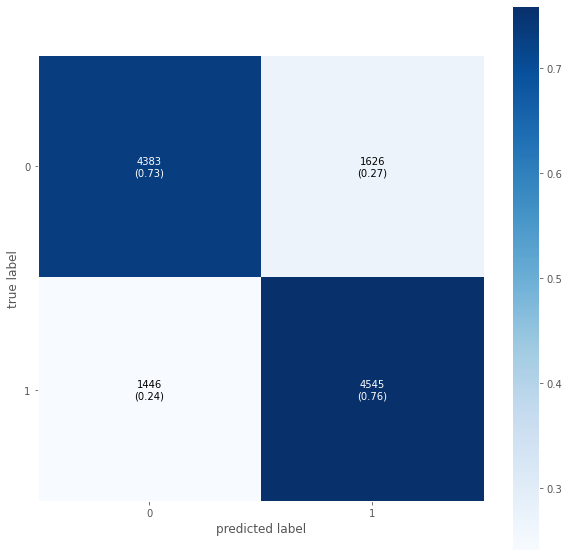

In [73]:
CR = confusion_matrix(Y_test,y_pred)
print(CR,'\n')
fig,ax = plot_confusion_matrix(conf_mat=CR,
                              figsize=(10,10),
                              show_absolute=True,
                              show_normed=True,
                              colorbar=True)
plt.show()

In [78]:
fpr, tpr, threshold = roc_curve(Y_test,y_pred, pos_label=1)

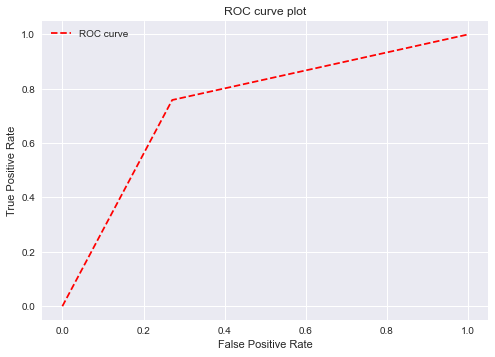

In [82]:
plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle='--',color='red', label='ROC curve')
plt.title('ROC curve plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show();